In [3]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import losses
from keras import optimizers
from keras import callbacks

from PIL import Image
import glob
import os
import numpy as np
from sklearn import utils 
from sklearn.model_selection import KFold
import IPython.display as dp
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import itemfreq
from math import floor, ceil
import random

## Load the data

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
Image.fromarray(X_train[0])

## Create the dataset

In [5]:
# Create an empty element matrix of 28 * 56 
test_image = np.zeros((28,56), dtype="uint8")

# Add the data from two image matrices from the training set
test_image[:,:28] = X_train[15]
test_image[:,28:] = X_train[2]
Image.fromarray(test_image)

In [6]:
# Generate the 100 unique combiantions of dataset from (0-9)
unique_pairs = [str(x)+str(y) for x in range(10) for y in range(10)]

# Create 10 combiantions of test set pairs
test_set_pairs = []

while(len(test_set_pairs) < 10):
    pair_to_add = random.choice(unique_pairs)
    if pair_to_add not in test_set_pairs:
        test_set_pairs.append(pair_to_add)

#Use the remaining 90 combinations as training set pairs
train_set_pairs = list(set(unique_pairs) - set(test_set_pairs))

print("Test set combinations", test_set_pairs)
print("Train set combinations",train_set_pairs)

Test set combinations ['98', '80', '88', '00', '91', '36', '31', '35', '20', '51']
Train set combinations ['59', '44', '67', '54', '48', '87', '71', '83', '03', '24', '08', '10', '74', '33', '09', '22', '93', '78', '39', '64', '95', '21', '69', '28', '37', '18', '53', '62', '46', '72', '55', '66', '82', '07', '01', '38', '68', '19', '85', '05', '61', '57', '70', '12', '41', '02', '43', '52', '92', '30', '23', '65', '34', '40', '58', '49', '97', '81', '13', '96', '73', '14', '77', '75', '15', '89', '42', '27', '50', '76', '04', '32', '11', '86', '79', '56', '26', '63', '94', '06', '99', '60', '47', '90', '16', '17', '84', '45', '25', '29']


## Data check

In [7]:
# Check for division of data into 90 training combinations and 10 test combinations
assert(len(test_set_pairs) == 10)
assert(len(train_set_pairs) == 90)

# Ensure no test combinations appear in the training set pairs:
for test_set in test_set_pairs:
    assert(test_set not in train_set_pairs)
    print("%s is not present in training set." % test_set)

98 is not present in training set.
80 is not present in training set.
88 is not present in training set.
00 is not present in training set.
91 is not present in training set.
36 is not present in training set.
31 is not present in training set.
35 is not present in training set.
20 is not present in training set.
51 is not present in training set.


## Generation of data based on opereator specific

In [98]:
X_train = []
y_train = []

# Number of samples per permutation (e.g. there are 90 permutations in the train set so 10 * 90)
samples_per_permutation = 10 

for train_set_pair in train_set_pairs:
    for _ in range(samples_per_permutation):
        rand_i = np.random.choice(np.where(y_train_keras == int(train_set_pair[0]))[0])
        rand_j = np.random.choice(np.where(y_train_keras == int(train_set_pair[1]))[0])
        
        temp_image = np.zeros((28,56), dtype="uint8")
        temp_image[:,:28] = X_train_keras[rand_i]
        temp_image[:,28:] = X_train_keras[rand_j]

        X_train.append(temp_image)
        y_train.append(y_train_keras[rand_i] + y_train_keras[rand_j])
        
X_test = []
y_test = []

for test_set_pair in test_set_pairs:
    for _ in range(samples_per_permutation):
        rand_i = np.random.choice(np.where(y_test_keras == int(test_set_pair[0]))[0])
        rand_j = np.random.choice(np.where(y_test_keras == int(test_set_pair[1]))[0])
        
        temp_image = np.zeros((28,56), dtype="uint8")
        temp_image[:,:28] = X_test_keras[rand_i]
        temp_image[:,28:] = X_test_keras[rand_j]
            
        X_test.append(temp_image)
        y_test.append(y_test_keras[rand_i] + y_test_keras[rand_j])


In [99]:
print("Training set size: %s, test set size: %s" % (len(X_train), len(X_test)))

# The training set should be 90,000 images in size (90 permutations * 10)
# and the label data, y_train, must also be equal in length.
assert(len(X_train) == samples_per_permutation * 90)
assert(len(X_train) == len(y_train))

# The test set should be 10,000 images in size (10 permutations * 10)
# and the label data, y_test, must also be equal in length
assert(len(X_test) == samples_per_permutation * 10)
assert(len(X_test) == len(y_test))

Training set size: 900, test set size: 100


Check for generated data in pairs with specific labels for specific operation

In [105]:
ind = random.randint(0, len(X_test))
print("Image label: " + str(y_test[ind]))
Image.fromarray(X_test[ind])


Image label: 8


In [59]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Reshape the data sets to a format suitable
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Reformat the images to use floating point values rather than integers between 0-255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Data Shuffling for better training
X_train, y_train = utils.shuffle(X_train, y_train)
X_test, y_test = utils.shuffle(X_test, y_test)

## Model Configuration

In [70]:
batch_size = 128
num_classes = 1               
epochs = 40
img_rows, img_cols = np.shape(X_train)[1], np.shape(X_train)[2]
input_shape = (img_rows, img_cols, 1)


######################################################
# Set up the network Model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))  
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
# specify one neuron
model.add(Dense(num_classes, activation='linear')) 


######################################################
# Configuration for an optimiser
rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
sgd = optimizers.SGD(learning_rate=0.0001, decay=1e-5, momentum=0.9, nesterov=True)
ada = optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
ndm = optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)


######################################################
# Compile the network.
model.compile(loss=losses.mean_absolute_error, optimizer=ada) ##mean absolute error or mean squared error 

## Train the model

In [71]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/40
8/8 [==============================] - 1s 75ms/step - loss: 2.5059 - val_loss: 2.6415
Epoch 2/40
8/8 [==============================] - 0s 41ms/step - loss: 1.9513 - val_loss: 2.9135
Epoch 3/40
8/8 [==============================] - 0s 40ms/step - loss: 2.0906 - val_loss: 1.7955
Epoch 4/40
8/8 [==============================] - 0s 40ms/step - loss: 1.9883 - val_loss: 2.7682
Epoch 5/40
8/8 [==============================] - 0s 41ms/step - loss: 1.9795 - val_loss: 2.9512
Epoch 6/40
8/8 [==============================] - 0s 40ms/step - loss: 2.0285 - val_loss: 2.0684
Epoch 7/40
8/8 [==============================] - 0s 40ms/step - loss: 1.9174 - val_loss: 2.3332
Epoch 8/40
8/8 [==============================] - 0s 40ms/step - loss: 2.0386 - val_loss: 2.3935
Epoch 9/40
8/8 [==============================] - 0s 39ms/step - loss: 1.8519 - val_loss: 1.8822
Epoch 10/40
8/8 [==============================] - 0s 40ms/step - loss: 1.8697 - val_loss: 1.9697
Epoch 11/40
8/8 [============

In [72]:
score = model.evaluate(X_test, y_test, verbose=1)
print("\n%.5f" % score)

4/4 [==============================] - 0s 5ms/step - loss: 2.8549

2.85488


## Visualise the data

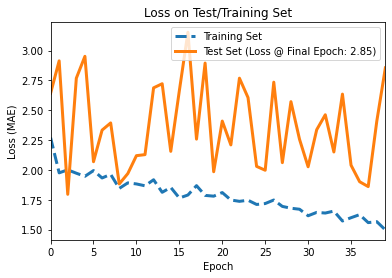

In [74]:
plt.xlim(0,len(history.history['loss'])-1)
plt.plot(history.history['loss'], linestyle='--', linewidth=3)
plt.plot(history.history['val_loss'], linewidth=3)
plt.title('Loss on Test/Training Set')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set (Loss @ Final Epoch: '+ str("%.2f"%score) +')'], loc='upper right')
plt.show()

## Make predictions

In [75]:
for _ in range(10):
    ind = random.randint(0, len(X_test)-1)
    image_predicted = X_test[ind].copy()
    image_predicted = image_predicted.reshape((28, 56))
    image_predicted = image_predicted * 255
    image_predicted = image_predicted.astype('uint8')
    dp.display_png(Image.fromarray(image_predicted))
    p = model.predict(X_test[ind].reshape(1, 28, 56, 1))[0][0]
    print("Prediction for %s: %s" % (y_test[ind], p))


Prediction for 9: 3.199156


Prediction for 3: 2.1361747


Prediction for 4: 2.012761


Prediction for 3: 0.43523163


Prediction for 4: 2.095119


Prediction for 9: 2.166675


Prediction for 3: 0.9133329


Prediction for 9: 2.8764627


Prediction for 3: 1.6514372


Prediction for 3: 0.76014584


## Check for correctness

In [57]:
correct = 0
incorrect = 0

for i in range(0, len(y_test)):
    prediction = model.predict(X_test[i].reshape(1, X_test[i].shape[0], X_test[i].shape[1], 1))[0][0]
    rounded_prediction = round(prediction)
    floor_prediction = floor(prediction)
    ceiling_prediction = ceil(prediction)
    
    abs_difference = abs(rounded_prediction-y_test[i])
    
    if abs_difference <= 1:
        correct = correct + 1
    else:
        incorrect = incorrect + 1
        
print("Correct: %s, incorrect: %s" % (correct, incorrect))


Correct: 45, incorrect: 55


# End of notebook

Note: The accuracy of prediction can further be increased by training for large number of samples and epochs with other validation techniques